# Grover's Algorithm

Grover's algorithm is a quantum protocol that has been demonstrated to over a polynomial speed up for the task for searching an unsorted list
over he best possible classical algorithm. 

Say we have a list of $N = 2^n$ elements containing numers. We are looking for an element which in the list which equals $w$, for some arb. number in the list.

A classical algorithm would check elements in a sequence if it equals $w$. In the worst case this requires $N$ checks, assuming that the marked element is in a random place in the list, the avergae number of checks that woudl need to be done to find $w$ is $N/2$, therefore the classical algorithm scales as $\mathcal{O}(N)$.

With Grover's algo this task can be accplished in time $\mathcal{O}(\sqrt{N})$. 

For the quantum algo we require Oracle access to the list, i.e. for each index $i$ some blackbox can retrive the value of the element at index $i$. Implementing a large list eg. a phone book is likely to be very slow on current quantum hardware, so for it is best to think of the problem in terms of satisfiabliity. Given a function of boolian contraints $f$, $f: \{0, 1\}^n \rightarrow \{0, 1\}$, we want to find $x$ such that $f(x) = 1$.

This is implementable with a phase oracle, $\hat{U}_f$:

$$
\hat{U}_f |x \rangle = (-1)^{f(x)} |x\rangle,
$$

i.e. $\hat{U}_f : |w\rangle \rightarrow -|w\rangle $ and $|x\rangle \rightarrow |x\rangle, \forall |x\rangle \neq |w\rangle$. Such an oracle can be implemented as a unitary operator:

$$\hat{U}_f = \mathbb{I} - 2|w\rangle\langle w|$$

In the algorithm we will need one more Oracle type operator:

$$\hat{U}_{f_0} =  2|0\rangle\langle 0|^{\otimes n} - \mathbb{I}$$.

$\hat{U}_{f_0} $ flips the phase of all states not equal to the $|00 ... 0\rangle = |0\rangle^{\otimes n}$, i.e. $|0\rangle^{\otimes n} \rightarrow  |0\rangle^{\otimes n}$ and $|x\rangle \rightarrow -|x\rangle$ for all $x \neq 00 ...0$


The sketch of the quantum circuit is given as follows:


<img src="Images/GroverSketch.png" style="height: 200; width:400px;"/>

The claim: $y = w $ (with high probability)

Proof:

Let us track the state of the state of the qubits through out the circuit. After the Hadamard gates in green the qubits are put in a evenly weighted superposition of the computational basis states $|0\rangle$ and $|1\rangle$, $|s \rangle = H^{\otimes n} |0\rangle^{\otimes n} =\frac{\sum_z(-1)^{x \cdot z}|z\rangle}{\sqrt{2^n}} $, but here $z = 00 ...0$ so the innerproduct in the exponent is always 0, which leasd to the simplification:  $|s\rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in\{0,1\}^n}|x\rangle$.

To understand the action of the rest of the circuit let us introduce some further notation: The part of the circuit marked in mageneta shall be denoted with $\hat{V} = H^{\otimes n} \cdot U_{f_0} \cdot H^{\otimes n} = H^{\otimes n} \cdot 2 |0\rangle \langle 0 |^{\otimes n} H^{\otimes n} - H^{\otimes n} \mathbb{I} H^{\otimes n} = 2 |s \rangle \langle 0| - \mathbb{I}$ (substituted the definition of $\hat{U}_{f_0}$ and simplified). This is called the diffuser in the qiskit textbook: https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

Grover's algoritm carries out the unitary operation (V U_{f})^r. To visulise the action of this operation let $\Sigma$ be the plane spanned by $|s\rangle$ and $|w\rangle$ and $|w ^{\perp}\rangle$ be the state orthogonal to $ |w\rangle $ in the plane $\Sigma$.

$$ |w ^{\perp}\rangle = \frac{1}{\sqrt{2^n - 1}} \sum_{x \neq w} |x\rangle$$
Then the superposition state can be written as:

$$
|s\rangle=\sqrt{\frac{2^n-1}{2^n}}\left|\omega^{\perp}\right\rangle+\frac{1}{\sqrt{2^n}}|\omega\rangle = 
\cos \frac{\theta}{2}\left|\omega^{\perp}\right\rangle+\sin \frac{\theta}{2}|\omega\rangle,
$$

where $\theta = 2 \arcsin(\frac{1}{\sqrt{2^n}})$


Then the protocol can be plotted in the plane sigma as follows:

<img src="Images/SigmaPlane.png" style="height: 400; width:400px;"/>


Protocol:

1. Prepare $|s\rangle$ (green)
2. Apply $U_f = \mathbb{I}-2 |w\rangle \langle w| $ $\Rightarrow$ Reflection about $\left|\omega^{\perp}\right\rangle$ (yellow)
3. Apply $V=2|s \rangle \rangle s | - \mathbb{I}$  $\Rightarrow$ Reflection about $|s\rangle$ (2 and 3 have the combined effect of rotating the oroginal state $|s\rangle$ by an angle $\theta$)

4. Repeat 2. and 3. $r$ times $\Rightarrow$ rotate $|s\rangle$  by $r\theta$

We chose $r$ such that the state $|s\rangle$ is rotated into the state $|w\rangle$, this means:
$$
r \cdot \theta+\frac{\theta}{2} \stackrel{!}{\approx} \frac{\pi}{2}  \Rightarrow r=\frac{\pi}{2 \theta}-\frac{1}{2}=\frac{\pi}{4 \cdot \arcsin( \frac{1}{\sqrt{2^n}})}-\frac{1}{2} \stackrel{\text{n large}}{\approx} \frac{\pi}{4} \sqrt{2^n}=\mathcal{O}(\sqrt{N})
$$
After $r$ calls to the Oracle the probability to measure $|w\rangle$ in the $\{|w\rangle, |w^{\perp}\rangle\}$ basis is:

$$
p(w) \geqslant 1-\sin ^2 \frac{\theta}{2}=1-\frac{1}{2^n}
$$

This finishes the proof of Grover's algorithm.



In [33]:
import numpy as np
from qiskit import QuantumCircuit, Aer,execute
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *

In [34]:
def PhaseOracle(n, indicies_to_mark, name = "U_f"):
    qc = QuantumCircuit(n, name = name)
    oracle_matrix = np.eye(2**n)
    for idx in indicies_to_mark:
        oracle_matrix[idx, idx] = -1  # diagonal matrix with 1 at all unmarked, -1 at all marked locs
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def Diffuser(n):
    qc = QuantumCircuit(n, name="V")
    qc.h(range(n)) # apply hadamard to all qubits (magenta)
    qc.append (PhaseOracle (n, [0]), range (n)) # U_{f_0}
    qc.h (range (n)) # apply hadamard to all qubits again (magenta)
    return qc

def GroverAlgo(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print (f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range (n)) # hadamard gates in green 
    for _ in range(r):
        qc.append(PhaseOracle(n, marked), range(n)) ## second argument where to connect the appended circuit element
        qc.append(Diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc
        

In [35]:
n = 4
x = np.random.randint(2 ** n)

print(marked)
qc = GroverAlgo(n, marked)

qc.draw()


[2]
4 qubits, basis state [2] marked, 3 rounds


┌───┐┌──────┐┌────┐┌──────┐┌────┐┌──────┐┌────┐┌─┐         
q_0: ┤ H ├┤0     ├┤0   ├┤0     ├┤0   ├┤0     ├┤0   ├┤M├─────────
     ├───┤│      ││    ││      ││    ││      ││    │└╥┘┌─┐      
q_1: ┤ H ├┤1     ├┤1   ├┤1     ├┤1   ├┤1     ├┤1   ├─╫─┤M├──────
     ├───┤│  U_f ││  V ││  U_f ││  V ││  U_f ││  V │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2     ├┤2   ├┤2     ├┤2   ├┤2     ├┤2   ├─╫──╫─┤M├───
     ├───┤│      ││    ││      ││    ││      ││    │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3     ├┤3   ├┤3     ├┤3   ├┤3     ├┤3   ├─╫──╫──╫─┤M├
     └───┘└──────┘└────┘└──────┘└────┘└──────┘└────┘ ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════╩══╩══╩══╩═
                                                     0  1  2  3

{'1001': 25, '1011': 28, '0110': 29, '1010': 27, '0101': 30, '0111': 19, '1101': 31, '1111': 20, '0001': 30, '0011': 18, '1110': 22, '0100': 29, '1100': 18, '1000': 21, '0000': 28, '0010': 9625}
2.6082688394304085


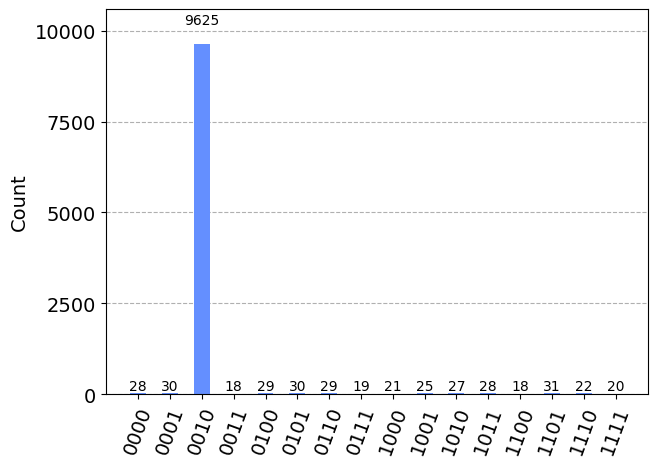

In [36]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots =10000).result()
counts = result.get_counts(qc)

print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)


In [ ]:
# the state 2 that was amrked here is exactly 0010 in binary. 
# The algo works. The propbability of getting the marked element is not 100% but it is very high,
# with the histogram the marked element can be indentidied clearly.
